In [1]:
import numpy as np
import tensorflow as tf
from IPython.display import HTML
from sklearn.preprocessing import StandardScaler
from node.core import get_node_function
from node.solvers import RK4Solver
from node.utils.trajectory import tracer, visualize_trajectory
from node.energy_based import Energy, energy_based, identity


# for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


DTYPE = 'float32'
tf.keras.backend.set_floatx(DTYPE)


class MyLayer(tf.keras.layers.Layer):

    def __init__(self, units, dt, num_grids, **kwargs):
        super().__init__(**kwargs)
        self.dt = dt
        self.num_grids = num_grids

        t0 = tf.constant(0., dtype=DTYPE)
        self.tN = t0 + num_grids * dt

        self._model = tf.keras.Sequential([
            tf.keras.layers.Dense(256, activation='relu', dtype=DTYPE),
            tf.keras.layers.Dense(units, dtype=DTYPE),
        ])
        self._model.build([None, units])

        self._raw_pvf = lambda _, x: self._model(x)
        self._energy = Energy(identity, self._raw_pvf)
        self._pvf = energy_based(identity, self._energy)
        self._node_fn = get_node_function(RK4Solver(self.dt, dtype=DTYPE),
                                          tf.constant(0., dtype=DTYPE),
                                          self._pvf)

    def call(self, x):
        y = self._node_fn(self.tN, x)
        return y

    def get_config(self):
        return super().get_config().copy()


def process(X, y):
    X = X / 255.
    X = np.reshape(X, [-1, 28 * 28])
    y = np.eye(10)[y]
    return X.astype(DTYPE), y.astype(DTYPE)


mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, y_train = process(x_train, y_train)
x_test, y_test = process(x_test, y_test)

scalar = StandardScaler()
scalar.fit(x_train)
x_train = scalar.transform(x_train)
x_test = scalar.transform(x_test)

model = tf.keras.Sequential([
    tf.keras.layers.Input([28 * 28]),
    tf.keras.layers.Dense(64, use_bias=False),  # down-sampling
    MyLayer(64, dt=1e-1, num_grids=10),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Nadam(1e-3, epsilon=1e-2),
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=12, batch_size=128)

Train on 60000 samples
Epoch 1/12
60000/60000 [==============================] - 45s 748us/sample - loss: 0.4339 - accuracy: 0.8760
Epoch 2/12
60000/60000 [==============================] - 46s 768us/sample - loss: 0.2232 - accuracy: 0.9356
Epoch 3/12
60000/60000 [==============================] - 39s 645us/sample - loss: 0.1699 - accuracy: 0.9498
Epoch 4/12
60000/60000 [==============================] - 39s 643us/sample - loss: 0.1376 - accuracy: 0.9589
Epoch 5/12
60000/60000 [==============================] - 39s 643us/sample - loss: 0.1148 - accuracy: 0.9663
Epoch 6/12
60000/60000 [==============================] - 43s 719us/sample - loss: 0.0979 - accuracy: 0.9708
Epoch 7/12
60000/60000 [==============================] - 44s 737us/sample - loss: 0.0847 - accuracy: 0.9748
Epoch 8/12
60000/60000 [==============================] - 43s 708us/sample - loss: 0.0743 - accuracy: 0.9776
Epoch 9/12
60000/60000 [==============================] - 42s 702us/sample - loss: 0.0652 - accuracy: 0.9

In [16]:
longer_trajectory_model = tf.keras.Sequential([
    tf.keras.layers.Input([28 * 28]),
    tf.keras.layers.Dense(64, use_bias=False),  # down-sampling
    MyLayer(64, dt=1e-1, num_grids=30),
    tf.keras.layers.Dense(10, activation='softmax')
])

longer_trajectory_model.compile(
    loss='categorical_crossentropy',
    metrics=['accuracy'])

longer_trajectory_model.set_weights(model.get_weights())
longer_trajectory_model.evaluate(x_train, y_train, batch_size=128)

60000/60000 [==============================] - 34s 566us/sample - loss: 0.0516 - accuracy: 0.9861


[0.0516377573877573, 0.98611665]

In [3]:
my_layer_id = 1
my_layer = model.layers[my_layer_id]
trace = tracer(RK4Solver(0.1), my_layer._pvf)
energy_fn = Energy(identity, my_layer._pvf)

truncated_model = tf.keras.Sequential(model.layers[:my_layer_id])
hidden = truncated_model(x_train[:100])
labels = y_train[:100]
trajectory = trace(t0=tf.constant(0.),
                   t1=tf.constant(10.),
                   dt=tf.constant(0.1),
                   x=hidden)
# trajectory = tf.stack([model.layers[3](_) for _ in tf.unstack(trajectory, axis=1)], axis=1)

def energy_along_trajectory(trajectory):
    shape = trajectory.get_shape().as_list()
    batch_size, trajectory_size, *phase_dims = shape
    phase_points = tf.reshape(trajectory, [-1, *phase_dims])
    e = energy_fn(phase_points)
    return tf.reshape(e, [batch_size, trajectory_size])


energy = energy_along_trajectory(trajectory)

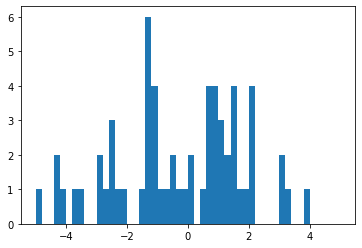

In [4]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt


i = 15
diffs = (trajectory[:,-1,:] - trajectory[:,0,:])
plt.hist(diffs[i], bins=50, range=(-5, 5))
plt.show()

In [5]:
labels_ = np.argmax(labels, -1)
print(list(enumerate(labels_)))

[(0, 5), (1, 0), (2, 4), (3, 1), (4, 9), (5, 2), (6, 1), (7, 3), (8, 1), (9, 4), (10, 3), (11, 5), (12, 3), (13, 6), (14, 1), (15, 7), (16, 2), (17, 8), (18, 6), (19, 9), (20, 4), (21, 0), (22, 9), (23, 1), (24, 1), (25, 2), (26, 4), (27, 3), (28, 2), (29, 7), (30, 3), (31, 8), (32, 6), (33, 9), (34, 0), (35, 5), (36, 6), (37, 0), (38, 7), (39, 6), (40, 1), (41, 8), (42, 7), (43, 9), (44, 3), (45, 9), (46, 8), (47, 5), (48, 9), (49, 3), (50, 3), (51, 0), (52, 7), (53, 4), (54, 9), (55, 8), (56, 0), (57, 9), (58, 4), (59, 1), (60, 4), (61, 4), (62, 6), (63, 0), (64, 4), (65, 5), (66, 6), (67, 1), (68, 0), (69, 0), (70, 1), (71, 7), (72, 1), (73, 6), (74, 3), (75, 0), (76, 2), (77, 1), (78, 1), (79, 7), (80, 9), (81, 0), (82, 2), (83, 6), (84, 7), (85, 8), (86, 3), (87, 9), (88, 0), (89, 4), (90, 6), (91, 7), (92, 4), (93, 6), (94, 8), (95, 0), (96, 7), (97, 8), (98, 3), (99, 1)]


In [6]:
def visualize(trajectory, label):
    print(f'label: {label}')
    anim = visualize_trajectory(trajectory.reshape([-1, 8, 8]), normalize=True)
    return HTML(anim.to_html5_video())

label: 5


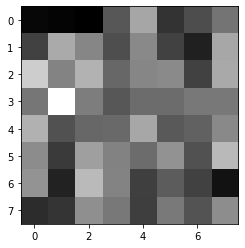

In [7]:
i = 0
visualize(trajectory.numpy()[i], labels_[i])

label: 5


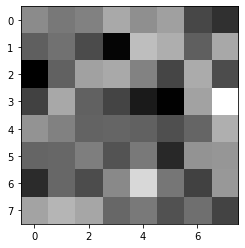

In [8]:
i = 11
visualize(trajectory.numpy()[i], labels_[i])

label: 5


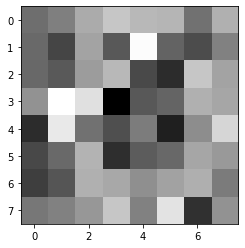

In [9]:
i = 35
visualize(trajectory.numpy()[i], labels_[i])

label: 6


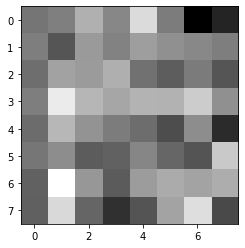

In [10]:
i = 36
visualize(trajectory.numpy()[i], labels_[i])

label: 7


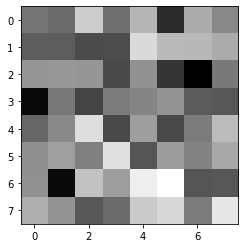

In [11]:
i = 38
visualize(trajectory.numpy()[i], labels_[i])

label: 3


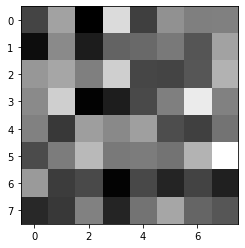

In [12]:
i = 50
visualize(trajectory.numpy()[i], labels_[i])

In [13]:
diffs = trajectory[:, 1:, :] - trajectory[:, :-1, :]

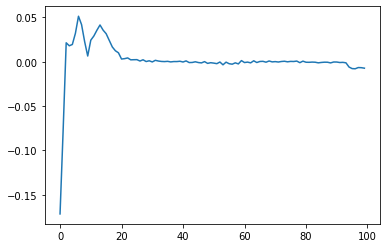

In [14]:
plt.plot(diffs[0, :, 20])
plt.show()

## Conclusion

For comparison, we do completely the same thing for the energy based and non-energy based models. Both models are in the same architecture. Nothing complicated is performed, including explicit regularization, early stopping, validation, e.t.c., for keeping experiments neat and concise.

### Training

#### Numeric Instability

The energy based model will triger the instability of RMSprop-like optimizers (e.g. Adam). The instability happens in the final stage of convergence, which is concisely explained [herein](https://datascience.stackexchange.com/a/25027). Tuning up the `epsilon` argument in the optimizer constructor is sufficient for solving this problem. This, however, will slow down the process in the early stage of convergence. This phenomenon is absent in the non-energy base model, meaning that the energy based model converges more tightly than the non-energy based.

#### Temporal Cost

The temporal cost is doubled comparing to non-energy based. This is caused by the fact that, in this very example, most of computation is spent in computing the `self._model(x)` within the NODE layer. The energy based model doubles the computation since an additional backward path is called, just doubles the DAG of the part. This also means that, except for the $\partial f / \partial z$, the energy based introduces no other computation.

### Convergence

After training, doubling (or tripling) the integration interval affects little on the loss and accuracy. (Doubling makes accuracy `98.7% -> 98.9%`, and tripling makes `98.7% -> 98.6%`.) While, for the non-energy based model, this affects quite a lot. (Doubling makes accuracy `99.3% -> 95.2%`, and tripling makes `99.3% -> 72.5%`.)


### Gradient Exploding?

Attractors may cause gradient exploding. $\partial L / \partial \theta = - \int_{t_1}^{t_0} \partial L / \partial z^{\alpha}(t) \partial f^{\alpha} / \partial \theta \left(z(t)\right)$, attractor from $t > t_0$ to $t_1$ leads to a constant integrand within interval $[t, t_1]$, thus accumulating the gradient linearly. Then, a long interval of attraction may cause large gradient. An adaptive time interval may rescure this situation.

This phenomenon has not been observed yet.